In [ ]:
#Questions
# - dense layer?
# - model doing better with less layers?
# - tuning layers
# - construct a class to test model differences
# - visualize model flow?
# - visualize filter outputs?
# - modeling doing better during validation than training?

In [101]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import time
import random

import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

### Data Exploration

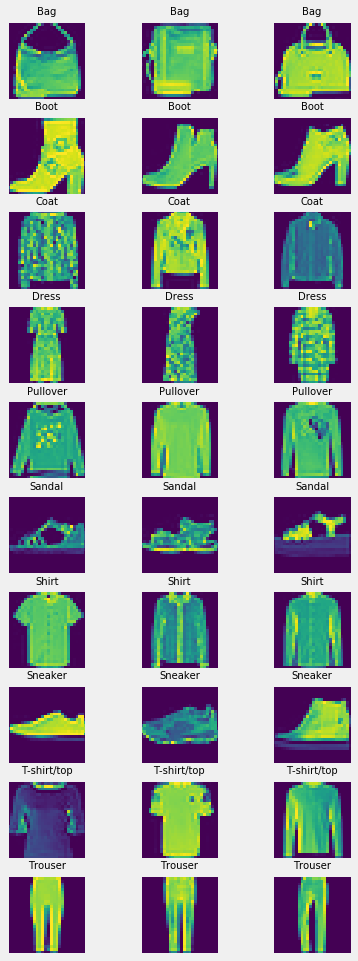

In [175]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

#plot sample of categories
test = list(zip(x_train, [categories[x] for x in y_train]))
test_df = pd.DataFrame(test)

function = lambda obj: obj.loc[np.random.choice(obj.index, 3, False)]
grouped = test_df.groupby(1).apply(function)

fig, axes = plt.subplots(10,3, figsize = (6,16))
axes = axes.flatten()
for i, image in enumerate(grouped[0]):
    axes[i].imshow(image)
    axes[i].set_title(grouped[1][i], size=10)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

### Data Processing and CNN

In [17]:
#scaling to ease computational burden of model
#note: scaling does not change the way the image renders
x_train_scaled = x_train/255
x_test_scaled = x_test/255

#convert to float 32 to use less space, float64 uses twice as much memory
x_train_scaled_32 = x_train_scaled.astype('float32')
x_test_scaled_32 = x_test_scaled.astype('float32')

#reshape to 4d array with expected input shape of (batch, rows, columns, channels)
x_train_scaled_shape = x_train_scaled_32.reshape(x_train_scaled_32.shape[0], 28, 28, 1)
x_test_scaled_shape = x_test_scaled_32.reshape(x_test_scaled_32.shape[0], 28, 28, 1)

#convert labels to one-hot-encoded arrays
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [183]:
class CNN:
    def __init__(self, **kwargs):
        self.metric_values = kwargs
        self.metric = list(kwargs)[0]
        self.test_values = list(kwargs.values())[0]
        
    def get_model(self, filter_value=5, kernel_value=(5,5)):
        initial_model = Sequential([Conv2D(filters=filter_value, kernel_size=kernel_value, activation='relu', input_shape=x_train_scaled_shape.shape[1:]),
                            Flatten(),
                           Dense(10, activation='softmax')])
        return initial_model
    
    def model_test(self):
        metric_values = self.metric_values
        test_values = metric_values.values()
        models=[]
        model_results=pd.DataFrame()
        for value in list(*test_values): 
            model_test = self.get_model(kernel_value=value)
            
            model_test.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
            
            #calculate time per model, fit model
            start_time = time.time()
            epochs=3
            results = model_kernel.fit(x_train_scaled_shape, y_train_cat, batch_size=100, epochs=epochs, verbose=1, validation_split=0.2)
            end_time = time.time()
            model_time = end_time-start_time

            #append model history to results_kernel dataframe
            history = pd.DataFrame(results.history)
            history['test'] = list(metric_values)[0]
            history['test_value'] = str(value)
            history['model_time'] = model_time
            history['epoch'] = list(range(1,epochs+1))
            model_results = model_results.append(history)
        return model_results

In [ ]:
mycnn = CNN(kernel=[(3,3),(5,5),(10,10),(28,28)])
mycnn.metric_values
model_results = mycnn.model_test()


In [ ]:
# datagen = ImageDataGenerator(rotation_range=10,
#                             zoom_range=0.1,
#                             width_shift_range=0.1,
#                             height_shift_range=0.1)

# epochs = 3
# batch_size = 100
# history = model_kernel.fit_generator(datagen.flow(x_train_sample, y_train_sample, batch_size=batch_size), epochs=epochs,
#                              validation_data=(x_test_sample, y_test_sample), steps_per_epoch=x_train_sample.shape[0//batch_size])


In [185]:
results_kernel

,val_loss,val_accuracy,loss,accuracy,kernel_dim,model_time,epoch
0,0.428661,0.851750,0.554553,0.808333,3,13.771840,1
1,0.396200,0.856833,0.400091,0.861188,3,13.771840,2
2,0.365966,0.872833,0.360697,0.875000,3,13.771840,3
3,0.350394,0.878417,0.334008,0.883000,3,13.771840,4
4,0.339000,0.881583,0.316054,0.889625,3,13.771840,5
0,0.401480,0.857500,0.530342,0.819083,5,20.250766,1
1,0.358541,0.873583,0.368749,0.871750,5,20.250766,2
2,0.330975,0.881667,0.326489,0.883917,5,20.250766,3
3,0.322424,0.887333,0.299329,0.894542,5,20.250766,4
4,0.306989,0.893667,0.279246,0.900625,5,20.250766,5


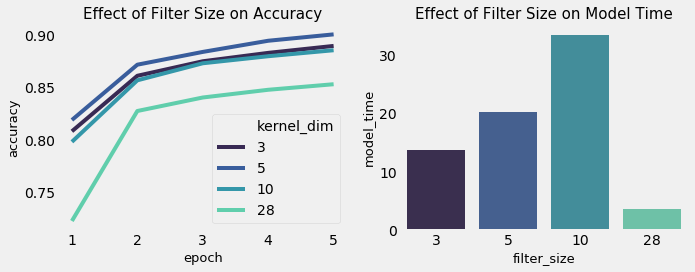

In [184]:
#visualize kernel size effect
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes = axes.flatten()

palette_size = len(results_kernel['kernel_dim'].unique())
plt.style.use('fivethirtyeight')
sns.lineplot(results_kernel['epoch'], results_kernel['accuracy'], hue=results_kernel['kernel_dim'],
            palette=sns.color_palette("mako", palette_size),ax = axes[0])
axes[0].set_title('Effect of Filter Size on Accuracy',size=15)
axes[0].set_xlabel('epoch',size=13)
axes[0].set_ylabel('accuracy', size=13)
axes[0].grid(False)

sns.barplot(results_kernel['kernel_dim'], results_kernel['model_time'], palette='mako', ax=axes[1])
axes[1].set_title('Effect of Filter Size on Model Time',size=15)
axes[1].set_xlabel('filter_size',size=13)
axes[1].set_ylabel('model_time', size=13)
axes[1].grid(False)
plt.tight_layout()

In [20]:
#effect of number of filters on results
filters = [5,10,30,50]
results_kernel = pd.DataFrame()
for filter_num in filters:
    model_kernel = Sequential([Conv2D(filters=filter_num, kernel_size=(3,3), activation='relu', input_shape=x_train_scaled_shape.shape[1:]),
                        Flatten(),
                       Dense(10, activation='softmax')])
    
    model_kernel.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    #calculate time per model
    start_time = time.time()
    epochs=5
    results = model_kernel.fit(x_train_scaled_shape, y_train_cat, batch_size=100, epochs=epochs, verbose=0, validation_split=0.2)
    end_time = time.time()
    model_time = end_time-start_time
    
    #append model history to results_kernel dataframe
    history = pd.DataFrame(results.history)
    history['filters'] = filter_num
    history['model_time'] = model_time
    history['epoch'] = list(range(1,epochs+1))
    results_kernel = results_kernel.append(history)
    

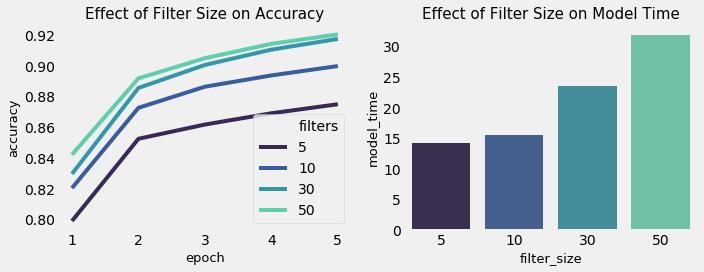

In [21]:
#visualize number of filters
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes = axes.flatten()

palette_size = len(results_kernel['filters'].unique())
plt.style.use('fivethirtyeight')
sns.lineplot(results_kernel['epoch'], results_kernel['accuracy'], hue=results_kernel['filters'],
            palette=sns.color_palette("mako", palette_size),ax = axes[0])
axes[0].set_title('Effect of Filter Size on Accuracy',size=15)
axes[0].set_xlabel('epoch',size=13)
axes[0].set_ylabel('accuracy', size=13)
axes[0].grid(False)

sns.barplot(results_kernel['filters'], results_kernel['model_time'], palette='mako', ax=axes[1])
axes[1].set_title('Effect of Filter Size on Model Time',size=15)
axes[1].set_xlabel('filter_size',size=13)
axes[1].set_ylabel('model_time', size=13)
axes[1].grid(False)
plt.tight_layout()

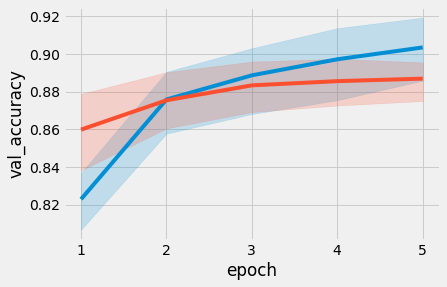

In [181]:
sns.lineplot(results_kernel['epoch'],results_kernel['accuracy'])
sns.lineplot(results_kernel['epoch'], results_kernel['val_accuracy'])

In [22]:
# datagen = ImageDataGenerator(rotation_range=10,
#                             zoom_range=0.1,
#                             width_shift_range=0.1,
#                             height_shift_range=0.1)

# epochs = 3
# batch_size = 100
# history = model.fit_generator(datagen.flow(x_train_sample, y_train_sample, batch_size=batch_size), epochs=epochs,
#                              validation_data=(x_test_sample, y_test_sample), steps_per_epoch=x_train_sample.shape[0//batch_size])


### Prediction analysis

In [24]:
#calculate predictions
predictions = model_kernel.predict(x_test_sample)

counts=Counter()
for x,y in zip(predictions, y_test):
    if np.argmax(x)==y:
        counts[y] +=1
        
counts

Counter({9: 956,
         2: 740,
         1: 977,
         6: 687,
         4: 916,
         5: 959,
         7: 962,
         3: 863,
         8: 970,
         0: 865})

In [37]:
#compare predicted to actuals
pred_labels = [np.argmax(x) for x in predictions]
pred_actual = pd.DataFrame(zip(y_test, pred_labels)).rename(columns={0:'actual', 1:'predicted'})
pred_actual['actual_label'] = pred_actual['actual'].map(categories)
pred_actual['predicted_label'] = pred_actual['predicted'].map(categories)
pred_actual['correct'] = pred_actual['actual'] == pred_actual['predicted']
pred_actual

pred_actual.groupby('actual_label')['correct'].aggregate({'sum':sum, 'total':len})

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  if __name__ == '__main__':


,sum,total
actual_label,,
Bag,970.0,1000
Boot,956.0,1000
Coat,916.0,1000
Dress,863.0,1000
Pullover,740.0,1000
Sandal,959.0,1000
Shirt,687.0,1000
Sneaker,962.0,1000
T-shirt/top,865.0,1000


In [94]:
test = incorrect.groupby(['actual_label','predicted_label'])['actual'].count().sort_values(ascending=False).to_frame()
test = test.reset_index()
test['labels'] = test['actual_label'] + '_'+ test['predicted_label']
test.head()

,actual_label,predicted_label,actual,labels
0,Pullover,Coat,147,Pullover_Coat
1,Shirt,T-shirt/top,134,Shirt_T-shirt/top
2,Shirt,Coat,106,Shirt_Coat
3,T-shirt/top,Shirt,96,T-shirt/top_Shirt
4,Pullover,Shirt,78,Pullover_Shirt


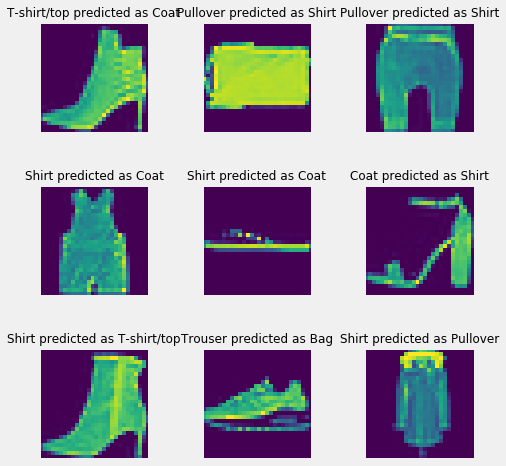

In [100]:
#closer look at shirts, most incorrectly predicted label
#something is very wrong with these labels lol
incorrect = pred_actual[pred_actual['actual_label']!=pred_actual['predicted_label']]
incorrect_indices = incorrect.index

sampling_incorrect = random.choices(incorrect_indices, k=9)
fig, axes = plt.subplots(3,3,figsize=(7,7))
axes = axes.flatten()

for i,index in enumerate(sampling_incorrect):
    actual_label = pred_actual.iloc[index]['actual_label']
    predicted_label = pred_actual.iloc[index]['predicted_label']
    axes[i].imshow(x_train_scaled[index])
    axes[i].set_title(actual_label +' predicted as '+predicted_label, size=12)
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()

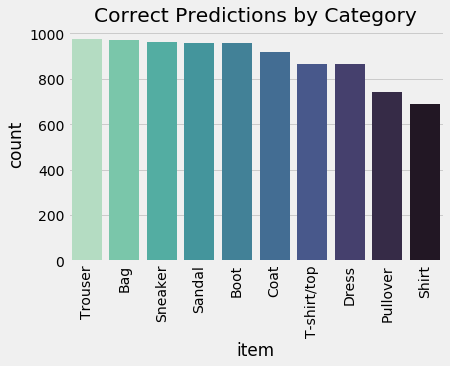

In [29]:
#plot frequency of accurate predictions by category
predicted = pd.DataFrame.from_dict(counts, orient='index').reset_index().rename(columns={'index':'label', 0:'count'})
predicted['item'] = predicted['label'].map(categories)
predicted = predicted.sort_values('count', ascending=False)
sns.barplot(predicted['item'], predicted['count'], palette='mako_r')
plt.title('Correct Predictions by Category')
ticks=plt.xticks(rotation='vertical')

In [30]:
#save and load a model
model.save('mnist_fashion.model')
new_model = tf.keras.models.load_model('mnist_fashion.model')